In [1]:
import torch
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
%matplotlib inline

In [2]:
# Input and output vectors are given. 
inp = [ 0.7300, -1.0400, -1.2300,  1.6700, -0.6300,  1.4300, -0.8400,  0.1500,
         -2.3000,  3.1000, -1.4500, -1.8100,  1.8700, -0.1100, -0.2800,  1.1200,
         -0.4200,  2.8900]
out = [ 1.43,  10.1,  8.3,  1.03,  10.21, -0.1,  8.92,  5.1,
         -7.53, 34.72,  7.61,  3.2,  2.19,  7.15,  7.69, -0.18,
          8.81, 23.1]

t_in = torch.tensor(inp)
t_out = torch.tensor(out)

In [3]:
# Define the polynomial model of degree 3, i.e., having 3 weights and 1 bias. 
# Also define the loss function

def model(t_in, w1, w2, w3, b):
    return w1*t_in**3 + w2*t_in**2 + w3*t_in + b

def loss_fn(t_pred, t_out):
    squared_diffs = (t_pred - t_out) ** 2
    return squared_diffs.mean()

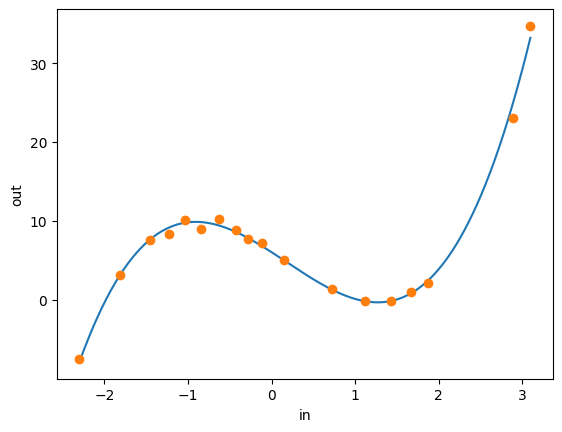

In [4]:
# Define gradient manually wrt the exisiting parameters
# Note: You need to define appropriate derivative functions to define the gradient
# Use the defined gradient function to define the training function 
# Note: You cannot use autograd and optimizers
# Run it on the input and output vector with appropriate learning rate and number of iterations
# Plot the learned curve

def dloss_fn(t_pred, t_out):
    dsq_diffs = 2 * (t_pred - t_out) / t_out.size(0)
    return dsq_diffs

def dmodel_dw1(w1, t_in, b):
    return t_in**3

def dmodel_dw2(w2, t_in, b):
    return t_in**2

def dmodel_dw3(t_in, b):
    return t_in

def dmodel_db(b):
    return 1.0

def grad_fn(t_in, t_out, t_pred, w1, w2, w3, b):
    dloss_dtp = dloss_fn(t_pred, t_out)
    dloss_dw1 = dloss_dtp * dmodel_dw1(w1, t_in, b)
    dloss_dw2 = dloss_dtp * dmodel_dw2(w2, t_in, b)
    dloss_dw3 = dloss_dtp * dmodel_dw3(t_in, b)
    dloss_db = dloss_dtp * dmodel_db(b)
    return torch.stack([
        dloss_dw1.sum(),
        dloss_dw2.sum(), 
        dloss_dw3.sum(), 
        dloss_db.sum()
    ])

def training_loop(n_epochs, learning_rate, params, t_in, t_out, print_params=True):
    for epoch in range(1, n_epochs + 1): 
        w1, w2, w3, b = params
        t_pred = model(t_in, w1, w2, w3, b)
        loss = loss_fn(t_pred, t_out)
        grad = grad_fn(t_in, t_out, t_pred, w1, w2, w3, b)
        params = params - learning_rate * grad
        if print_params:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params

# params = torch.tensor([1.0, 1.0, 1.0, 0.0])

params = training_loop(
    n_epochs = 10000,
    learning_rate = 1e-3,
    params = torch.tensor([1.0, 1.0, 1.0, 0.0]),
    t_in = t_in,
    t_out = t_out,
    print_params=False
)
t_pred = model(t_in, *params)

cubic_interp_model = interp1d(t_in.numpy(), t_pred.detach().numpy(), kind="cubic")
X_ = np.linspace(t_in.numpy().min(), t_in.numpy().max(), 500)
Y_ = cubic_interp_model(X_)

fig = plt.figure(dpi=100)
plt.xlabel("in")
plt.ylabel("out")
plt.plot(X_, Y_)
plt.plot(t_in.numpy(), t_out.numpy(), 'o')

Epoch 500, Loss 19.207664
Epoch 1000, Loss 8.066436
Epoch 1500, Loss 3.550542
Epoch 2000, Loss 1.716168
Epoch 2500, Loss 0.969645
Epoch 3000, Loss 0.665330
Epoch 3500, Loss 0.541107
Epoch 4000, Loss 0.490334
Epoch 4500, Loss 0.469561
Epoch 5000, Loss 0.461053
Epoch 5500, Loss 0.457566
Epoch 6000, Loss 0.456135
Epoch 6500, Loss 0.455548
Epoch 7000, Loss 0.455308
Epoch 7500, Loss 0.455208
Epoch 8000, Loss 0.455168
Epoch 8500, Loss 0.455150
Epoch 9000, Loss 0.455143
Epoch 9500, Loss 0.455140
Epoch 10000, Loss 0.455140


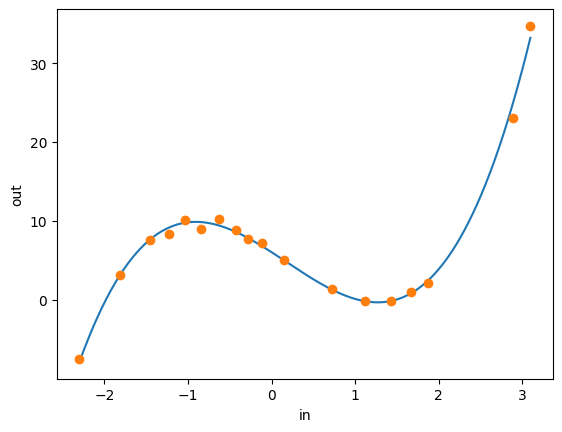

In [5]:
# Use PyTorch's autograd to automatically compute the gradients 
# Define the training function
# Note: You cannot use optimizers.
# Run it on the input and output vector with appropriate learning rate and number of iterations
# Plot the learned curve

def training_loop_auto(n_epochs, learning_rate, params, t_in, t_out):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:
            params.grad.zero_()
        t_pred = model(t_in, *params)
        loss = loss_fn(t_pred, t_out)
        loss.backward()
        with torch.no_grad():
            params -= learning_rate * params.grad
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params

params = training_loop_auto(
    n_epochs = 10000,
    learning_rate = 1e-3,
    params = torch.tensor([1.0, 1.0, 1.0, 0.0], requires_grad=True),
    t_in = t_in,
    t_out = t_out,
)
loss = loss_fn(model(t_in, *params), t_out)
loss.backward()
t_pred = model(t_in, *params)

cubic_interp_model = interp1d(t_in.numpy(), t_pred.detach().numpy(), kind="cubic")
X_ = np.linspace(t_in.numpy().min(), t_in.numpy().max(), 500)
Y_ = cubic_interp_model(X_)

fig = plt.figure(dpi=100)
plt.xlabel("in")
plt.ylabel("out")
plt.plot(X_, Y_)
plt.plot(t_in.numpy(), t_out.numpy(), 'o')

Epoch 500, Loss 19.207664
Epoch 1000, Loss 8.066436
Epoch 1500, Loss 3.550542
Epoch 2000, Loss 1.716168
Epoch 2500, Loss 0.969645
Epoch 3000, Loss 0.665330
Epoch 3500, Loss 0.541107
Epoch 4000, Loss 0.490334
Epoch 4500, Loss 0.469561
Epoch 5000, Loss 0.461053
Epoch 5500, Loss 0.457566
Epoch 6000, Loss 0.456135
Epoch 6500, Loss 0.455548
Epoch 7000, Loss 0.455308
Epoch 7500, Loss 0.455208
Epoch 8000, Loss 0.455168
Epoch 8500, Loss 0.455150
Epoch 9000, Loss 0.455143
Epoch 9500, Loss 0.455140
Epoch 10000, Loss 0.455140


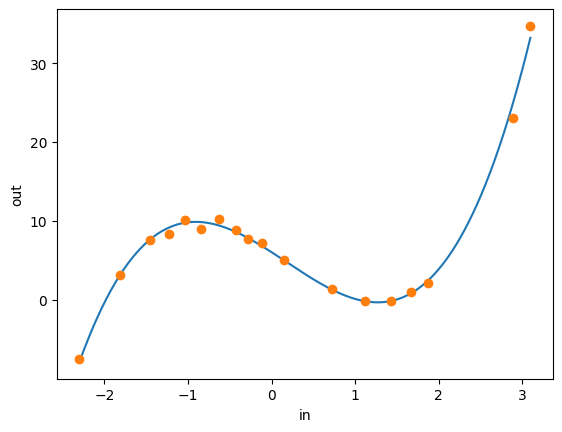

In [19]:
# Use PyTorch's autograd to automatically compute the gradients 
# Use optimizers to abstract how parameters get updated
# Define the training function
# Run it on the input and output vector with appropriate learning rate, number of iterations, and SGD optimizer
# Plot the learned curve
def training_loop_opt(n_epochs, optimizer, params, t_in, t_out):
    for epoch in range(1, n_epochs + 1):
        t_pred = model(t_in, *params)
        loss = loss_fn(t_pred, t_out)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params

params = torch.tensor([1.0, 1.0, 1.0, 0.0], requires_grad=True)
learning_rate = 1e-3
optimizer = optim.SGD([params], lr=learning_rate)

training_loop_opt(
    n_epochs = 10000,
    optimizer = optimizer,
    params = params,
    t_in = t_in,
    t_out = t_out
)
t_pred = model(t_in, *params)

cubic_interp_model = interp1d(t_in.numpy(), t_pred.detach().numpy(), kind="cubic")
X_ = np.linspace(t_in.numpy().min(), t_in.numpy().max(), 500)
Y_ = cubic_interp_model(X_)

fig = plt.figure(dpi=100)
plt.xlabel("in")
plt.ylabel("out")
plt.plot(X_, Y_)
plt.plot(t_in.numpy(), t_out.numpy(), 'o')

Epoch 1, Training loss 115.0845, Validation loss 224.0594
Epoch 2, Training loss 114.9366, Validation loss 223.7307
Epoch 3, Training loss 114.7893, Validation loss 223.4029
Epoch 500, Training loss 82.8213, Validation loss 134.4828
Epoch 1000, Training loss 78.0426, Validation loss 108.0829
Epoch 1500, Training loss 77.0096, Validation loss 98.5536
Epoch 2000, Training loss 76.4987, Validation loss 94.3596
Epoch 2500, Training loss 76.0743, Validation loss 92.0268
Epoch 3000, Training loss 75.6768, Validation loss 90.3842


NameError: name 't_i' is not defined

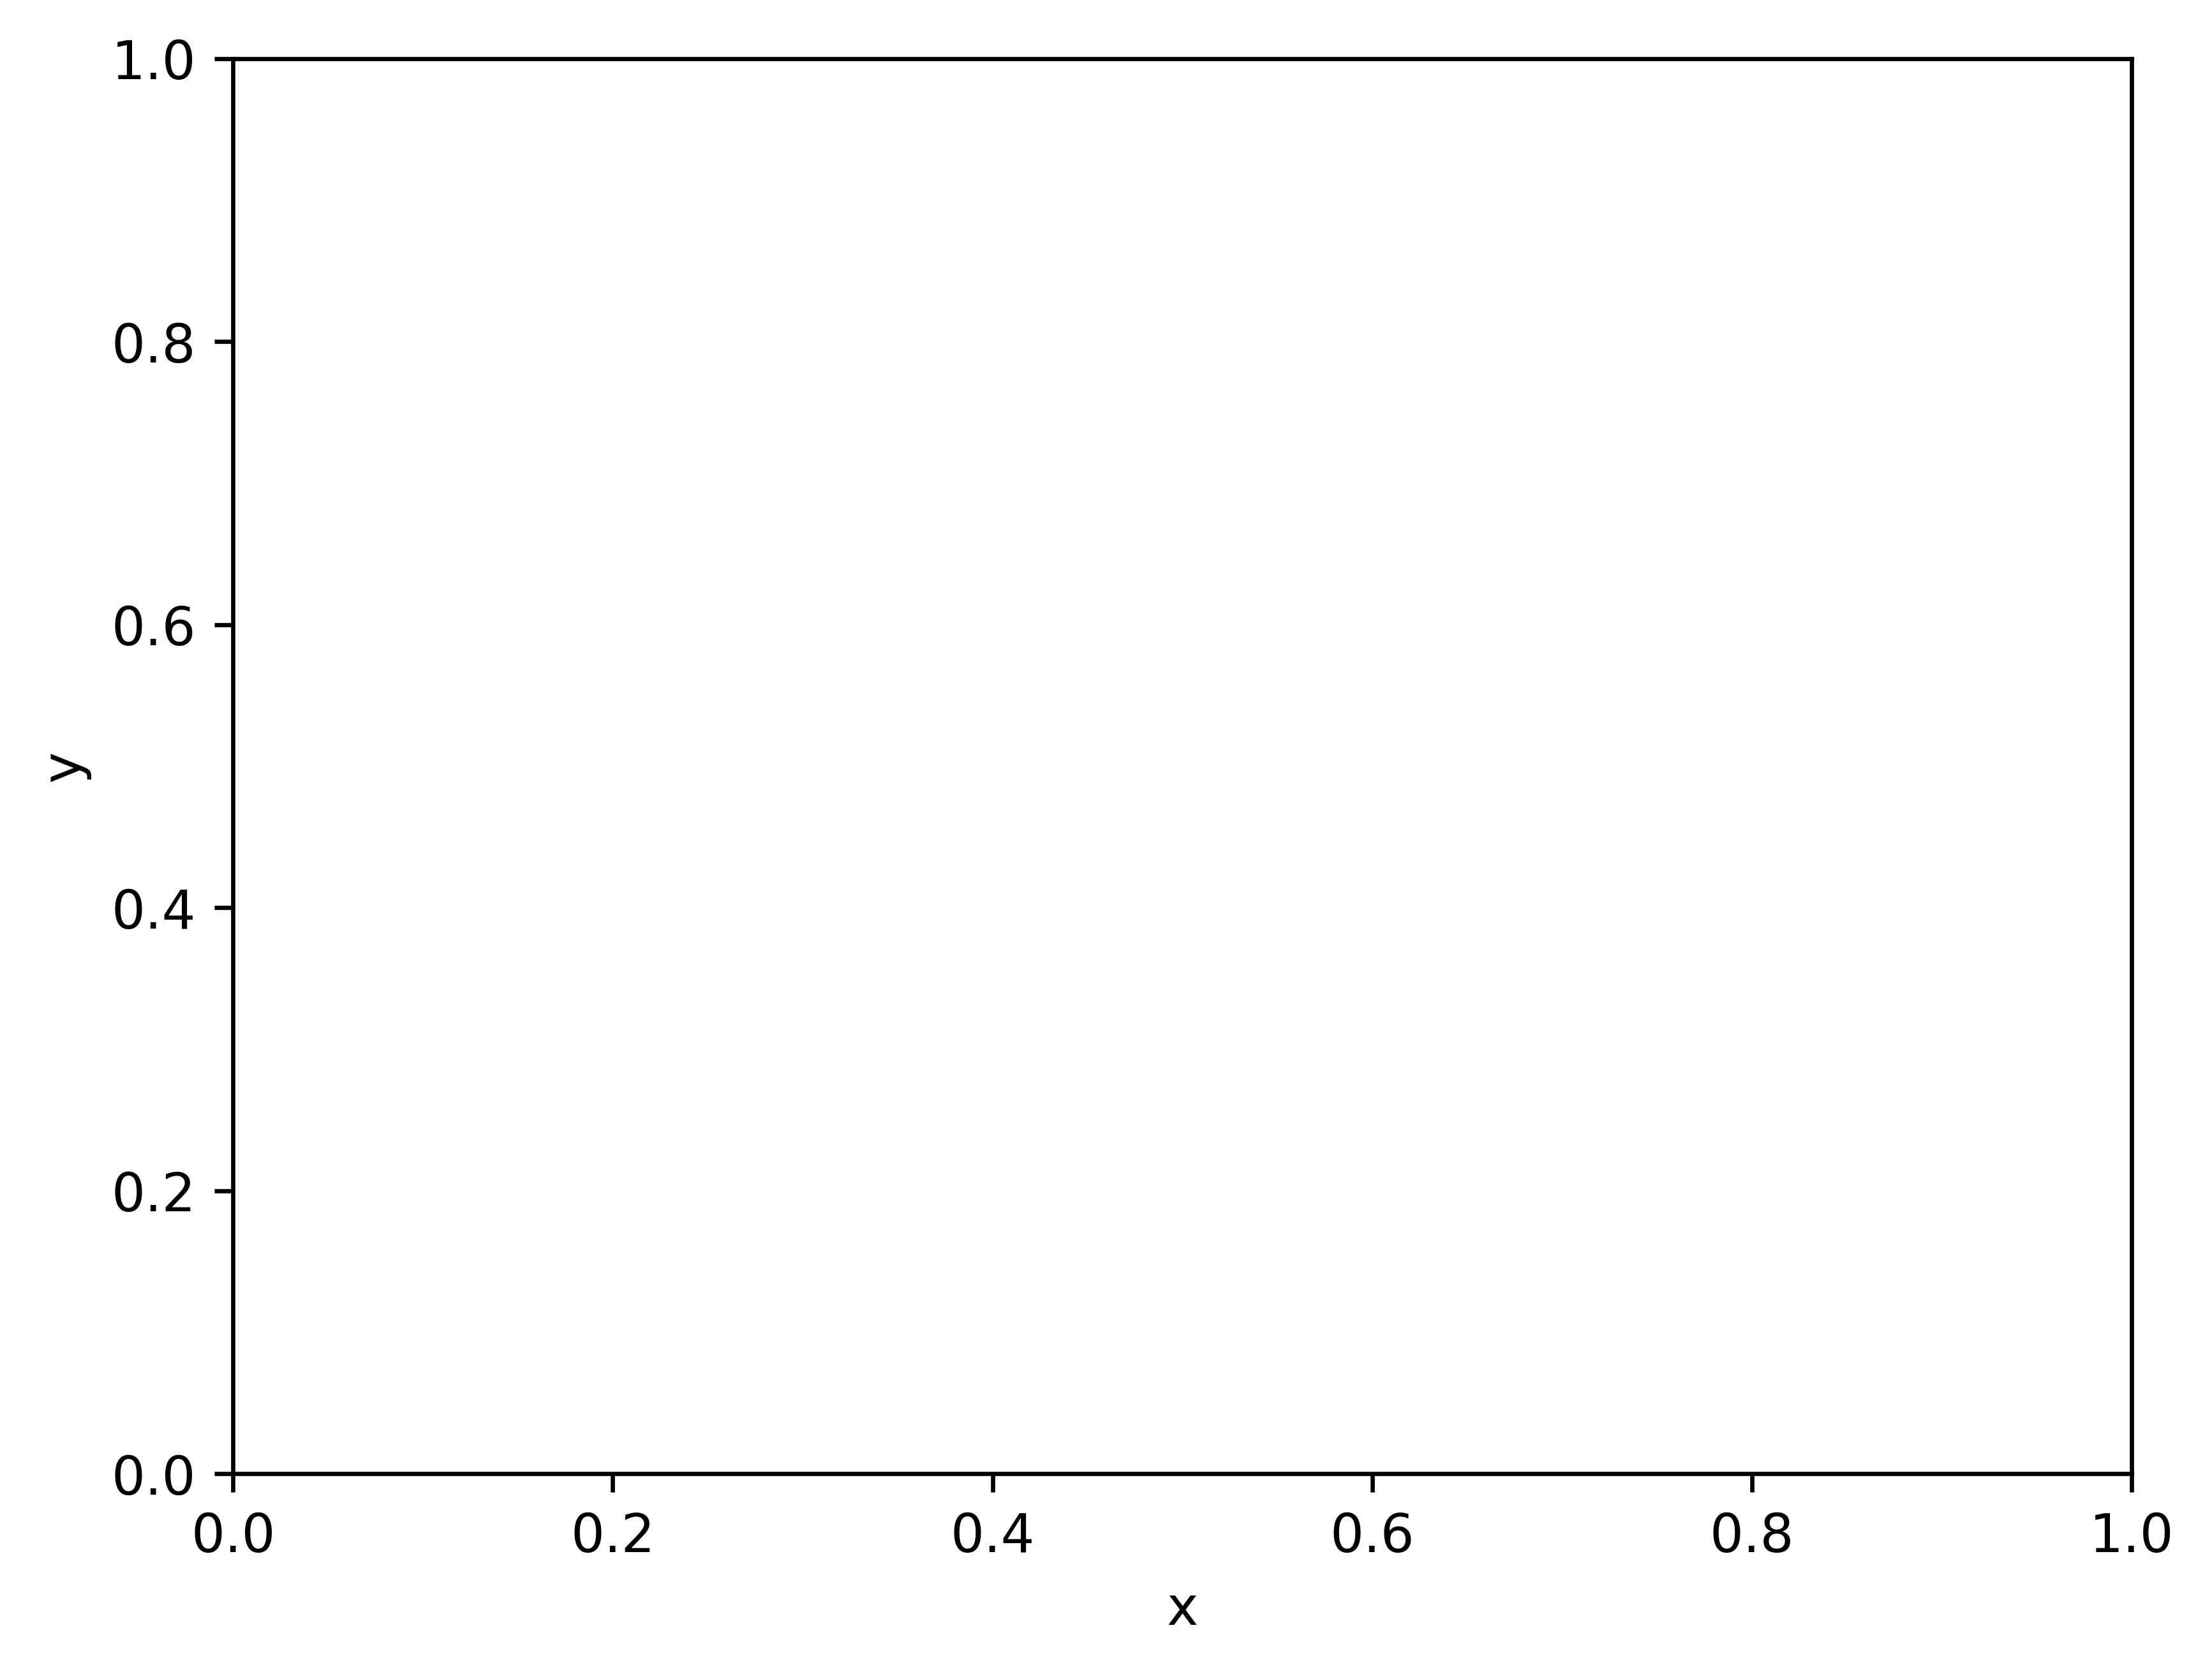

In [21]:
# Split the dataset to training set (80%) and validation set (20%) randomly
# Use PyTorch's autograd to automatically compute the gradients 
# Use optimizers to abstract how parameters get updated
# Define the training function that tracks both training and validation losses
# Run it on the input and output vector with appropriate learning rate, number of iterations, and SGD optimizer
# Plot the learned curve

def training_loop(n_epochs, optimizer, params, train_t_in, val_t_in, train_t_out, val_t_out):
    for epoch in range(1, n_epochs + 1):
        train_t_pred = model(train_t_in, *params)
        train_loss = loss_fn(train_t_pred, train_t_out)
        val_t_pred = model(val_t_in, *params)
        val_loss = loss_fn(val_t_pred, val_t_out)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Validation loss {val_loss.item():.4f}")
    return params

n_samples = t_in.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

train_t_in = t_in[train_indices]
train_t_out = t_out[train_indices]
val_t_in = t_in[val_indices]
val_t_out = t_out[val_indices]

train_t_in = 0.1 * train_t_in
val_t_in = 0.1 * val_t_in

params = torch.tensor([1.0, 1.0, 1.0, 0.0], requires_grad=True)
learning_rate = 1e-3
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    params = params,
    train_t_in = train_t_in,
    val_t_in = val_t_in,
    train_t_out = train_t_out,
    val_t_out = val_t_out
)

fig = plt.figure(dpi=600)
plt.xlabel("x")
plt.ylabel("y")
plt.plot(t_i.numpy(), t_p.detach().numpy())
plt.plot(t_i.numpy(), t_o.numpy(), 'o')